In [3]:
import pandas as pd 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy.random import default_rng
import os 

from functions_data import binarise_using_average, binarise_using_max, import_data, shuffle_data

In [5]:
def question_difficulty_model(non_binarised_data, questions_info, binarisation_method, shuffle):

    if shuffle:
        non_binarised_data = shuffle_data(non_binarised_data)  # shuffle columns of the dataset

    if binarisation_method == 'average':
        data = binarise_using_average(non_binarised_data)
    if binarisation_method == 'max':
        data = binarise_using_max(non_binarised_data, questions_info)

    students_separation_point = 22511
    questions_separation_point = 12
    question_labels = data.columns

    test = data[question_labels[questions_separation_point:]][students_separation_point:]
    train = data[question_labels[questions_separation_point:]][:students_separation_point]
    test.reset_index(inplace=True, drop=True)
    train.reset_index(inplace=True, drop=True)
    
    p = train.sum(axis=0) / train.shape[0]

    correctness = []
    for seed_number in range(100):
        rng = default_rng(seed=seed_number)
        correct = 0
        for col in test:
            pred = rng.binomial(1, p[col], test.shape[0])
            correct += np.count_nonzero(pred == test[col])
        correctness.append(correct / test.size * 100)

    acc, std = np.mean(correctness), np.std(correctness)

    # plt.figure(0)
    # plt.hist(p, bins=13)
    # plt.title('Histogram of question parameter')
    # save_path = os.path.join(os.getcwd(), 'figures', 'hist_quest_param_max_shuffled.png')
    # plt.savefig(save_path)

    # plt.figure(1)
    # plt.bar(test.columns, height=p)
    # plt.title('Bar plot of question parameter')
    # save_path = os.path.join(os.getcwd(), 'figures', 'barplot_quest_param_max_shuffled.png')
    # plt.savefig(save_path)

    return acc, std


def student_ability_model(non_binarised_data, questions_info, binarisation_method, shuffle):

    if shuffle:
        non_binarised_data = shuffle_data(non_binarised_data, 1000)  # shuffle columns of the dataset

    if binarisation_method == 'average':
        data = binarise_using_average(non_binarised_data)
    if binarisation_method == 'max':
        data = binarise_using_max(non_binarised_data, questions_info)

    students_separation_point = 22511
    questions_separation_point = 12
    question_labels = data.columns

    test = data[question_labels[questions_separation_point:]][
           students_separation_point:]  # test set will be 13 questions
    train = data[question_labels[:questions_separation_point]][students_separation_point:]
    test.reset_index(inplace=True, drop=True)
    train.reset_index(inplace=True, drop=True)

    p = train.sum(axis=1) / train.shape[1]

    correctness = []
    for seed_number in range(10):
        correct = 0
        rng = default_rng(seed=seed_number)
        for index, student in test.iterrows():
            pred = rng.binomial(1, p[index], test.shape[1])
            correct += np.count_nonzero(pred == student)
        correctness.append(correct / test.size * 100)

    acc = np.mean(correctness)
    std = np.std(correctness)

    # plt.figure(0)
    # plt.hist(p, bins=13)
    # plt.title('Histogram of student parameter')
    # plt.savefig('C:/Users/Anastasija/Desktop/FYP Personalised Education/figures/hist_student_param_max_shuffled.png')

    # plt.figure(1)
    # plt.bar(range(test.shape[0]), height=p)
    # plt.title('Bar plot of student parameter')
    # plt.savefig('C:/Users/Anastasija/Desktop/FYP Personalised Education/figures/barplot_student_param_max_shuffled.png')

    return acc, std


def corr_matrix_questions(data, save_location):
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(16, 16))
    sns.heatmap(data.corr(), annot=True, fmt=".2f", ax=ax, xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    plt.savefig(save_location)
    plt.show()


def zeros_ones_data(data, questions_info):
    binarised_using_avg = binarise_using_average(data)
    binarised_using_max = binarise_using_max(data, questions_info)

    bin_avg_frac = binarised_using_avg.values.sum() / binarised_using_avg.size * 100
    bin_max_frac = binarised_using_max.values.sum() / binarised_using_max.size * 100

    print('Fraction of ones in the dataset binarised using average of the question score is ',
          "{0:0.2f}".format(bin_avg_frac), "%")
    print('Fraction of ones in the dataset binarised using max possible question score is ',
          "{0:0.2f}".format(bin_max_frac), "%")


def run_model(data, questions_info, model, binarisation_method, shuffle):

    if model == 'question_difficulty':
        acc, std = question_difficulty_model(data, questions_info, binarisation_method, shuffle)
        if shuffle:
            print('Question difficulty model with shuffled columns accuracy: ', acc, ' standard deviation: ', std,
                  'binarisation method ', binarisation_method)
        else:
            print('Question difficulty model without shuffled columns accuracy: ', acc, ' standard deviation: ', std,
                  'binarisation method ', binarisation_method)

    if model == 'student_ability':
        acc, std = student_ability_model(data, questions_info, binarisation_method=binarisation_method, shuffle=shuffle)
        if shuffle:
            print('Student ability model with shuffled columns accuracy: ', acc, ' standard deviation: ', std,
                  'binarisation method ', binarisation_method)
        else:
            print('Student ability model without shuffled columns accuracy: ', acc, ' standard deviation: ', std,
                  'binarisation method ', binarisation_method)

data_file = os.path.join(os.getcwd(), 'data', '9to1_2017_GCSE_1H.csv')
df, q_info = import_data(data_file)

model_ = 'question_difficulty'
shuffle_ = False
binarisation_method_ = 'max'
run_model(df, q_info, model_, binarisation_method_, shuffle_)

# accs = []
# sep_points = np.arange(100, 22511, 100)
# for sep_point in sep_points:
#     acc = run_model(df, q_info, model_, binarisation_method_, shuffle_, sep_point)
#     accs.append(acc)
#     print(sep_point)
# plt.plot(sep_points, accs)
# plt.xlabel('Number of students in the training set')
# plt.ylabel('Accuracy of the question-difficulty model')
# plt.show()


/Users/anastasijailic/Library/Mobile Documents/com~apple~CloudDocs/Master/functions_data.py:11: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(datafile)


Question difficulty model without shuffled columns accuracy:  69.50143633482891  standard deviation:  0.07223069066192668 binarisation method  max


In [15]:
model = 'question_difficulty'
shuffle = True 
binarisation_method = 'max'

data_file = os.path.join(os.getcwd(), 'data', '9to1_2017_GCSE_1H.csv')
df, q_info = import_data(data_file)

non_binarised_data = df 

if shuffle:
    non_binarised_data = shuffle_data(non_binarised_data)  # shuffle columns of the dataset

if binarisation_method == 'average':
    data = binarise_using_average(non_binarised_data)
if binarisation_method == 'max':
    data = binarise_using_max(non_binarised_data, q_info)

students_separation_point = 22511
questions_separation_point = 12
question_labels = data.columns


test = data[question_labels[questions_separation_point:]][students_separation_point:]
train = data[question_labels[questions_separation_point:]][:students_separation_point]
print(test, train)
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)

p = train.sum(axis=0) / train.shape[0]

ones = 0 
correctness = []
seed_number = 1000
rng = default_rng(seed=seed_number)
correct = 0
for col in test:
    pred = rng.binomial(1, p[col], test.shape[0])
    ones += pred.sum()
    correct += np.count_nonzero(pred == test[col])
correctness.append(correct / test.size * 100)

acc, std = np.mean(correctness), np.std(correctness)



       q16   q5  q12  q13  q10   q9  q14  q22   q2   q1   q8  q20
22511  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
22512  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
22513  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
22514  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
22515  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
45017  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0
45018  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
45019  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0
45020  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0
45021  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0

[22511 rows x 12 columns]        q16   q5  q12  q13  q10   q9  q14  q22   q2   q1   q8  q20
0      0.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0
1      0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.

/Users/anastasijailic/Library/Mobile Documents/com~apple~CloudDocs/Master/functions_data.py:11: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(datafile)


In [13]:
print(test.shape)
print(train.shape)

(22511, 12)
(22511, 12)


In [14]:
print(train)
print(test)

       q16   q5  q12  q13  q10   q9  q14  q22   q2   q1   q8  q20
0      0.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0
1      0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0
2      0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0
3      0.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0
4      0.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
22506  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
22507  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0
22508  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
22509  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
22510  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[22511 rows x 12 columns]
       q16   q5  q12  q13  q10   q9  q14  q22   q2   q1   q8  q20
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

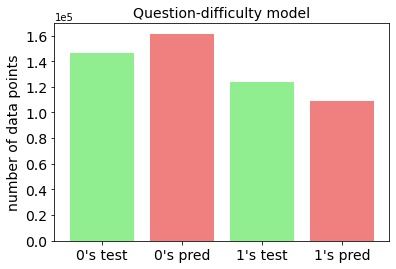

108738
62.696755660195755


In [46]:
test_zeros = test.shape[0]*test.shape[1] - int(test.sum().sum())
test_ones = int(test.sum().sum())

predicted_zeros = test.shape[0]*test.shape[1] - ones
predicted_ones  = ones
x = [test_zeros, predicted_zeros, test_ones, predicted_ones]

plt.bar(['0\'s test', '0\'s pred', '1\'s test', '1\'s pred'], height=x,color=['lightgreen','lightcoral','lightgreen','lightcoral'])
plt.title('Question-difficulty model', fontsize = 14)
plt.ylabel('number of data points', fontsize=14)
plt.ticklabel_format(axis = 'y', style='sci', scilimits=(0,0))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()
print(ones)
print(acc)

In [57]:
model = 'student_ability'
shuffle = True 
binarisation_method = 'max'

data_file = os.path.join(os.getcwd(), 'data', '9to1_2017_GCSE_1H.csv')
df, q_info = import_data(data_file)

non_binarised_data = df 

if shuffle:
    non_binarised_data = shuffle_data(non_binarised_data)  # shuffle columns of the dataset

if binarisation_method == 'average':
    data = binarise_using_average(non_binarised_data)
if binarisation_method == 'max':
    data = binarise_using_max(non_binarised_data, q_info)

students_separation_point = 22511
questions_separation_point = 12
question_labels = data.columns

test = data[question_labels[questions_separation_point:]][students_separation_point:]
train = data[question_labels[questions_separation_point:]][:students_separation_point]
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)

p = train.sum(axis=1) / train.shape[1]

seed_number = 1000 

correctness = []
correct = 0
ones = 0
rng = default_rng(seed=seed_number)
for index, student in test.iterrows():
    pred = rng.binomial(1, p[index], test.shape[1])
    ones += pred.sum()
    correct += np.count_nonzero(pred == student)
correctness.append(correct / test.size * 100)

acc = np.mean(correctness)
std = np.std(correctness)


/Users/anastasijailic/Library/Mobile Documents/com~apple~CloudDocs/Master/functions_data.py:11: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(datafile)


In [58]:
print(acc)

51.077621311062735


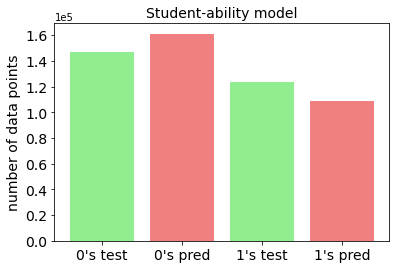

In [38]:
test_zeros = test.shape[0]*test.shape[1] - int(test.sum().sum())
test_ones = int(test.sum().sum())

predicted_zeros = test.shape[0]*test.shape[1] - ones
predicted_ones  = ones
x = [test_zeros, predicted_zeros, test_ones, predicted_ones]

plt.bar(['0\'s test', '0\'s pred', '1\'s test', '1\'s pred'], height=x,color=['lightgreen','lightcoral','lightgreen','lightcoral'])
plt.title('Student-ability model', fontsize = 14)
plt.ylabel('number of data points', fontsize=14)
plt.ticklabel_format(axis = 'y', style='sci', scilimits=(0,0))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

In [42]:
print(acc)

62.696755660195755
